In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [4]:
R0, kappa = 1.5, 0
N = 1e7
xi = 50
ds = xi*np.logspace(-1,1,21)

muN=1000
R_d = lambda d, dbar: np.exp(-(d-1)/dbar)
dbar=  10

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]


Text(0, 0.5, 'time interval, [generation time]')

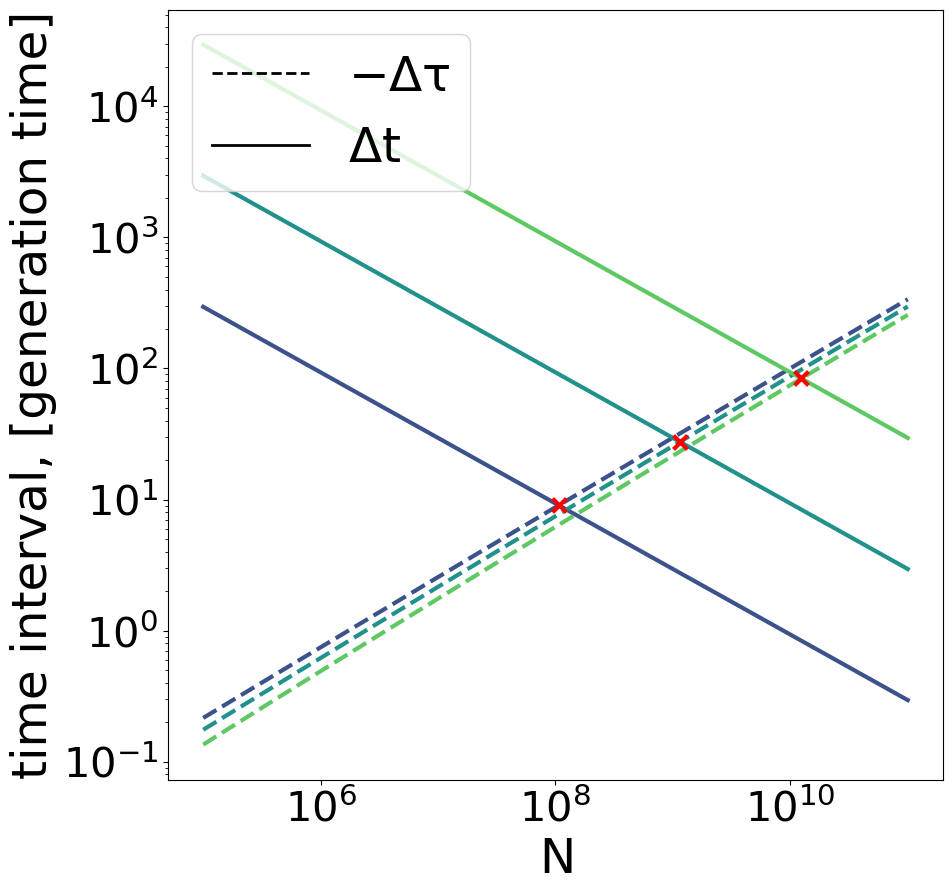

In [20]:
mu = 1e-8
N_arr = np.logspace(5,11,100)
delta = 1/5
kappa_s = [10,100,1000]
R0 = 2.5
muN_arr = mu*N_arr

c_d = lambda d,xi: np.exp(-d/xi)

colors_kappa = dict(zip(kappa_s, sns.color_palette('viridis', len(kappa_s))))
fig,axx= plt.subplots(1,1,figsize=(10,10))

for kappa in kappa_s:   
    d1 = 2*dbar
    d2 = d1 + dbar
    t1 = kappa/(R0-1)* np.sqrt(np.pi/(2*muN_arr*delta))
    t2 = kappa/(R0-1)* np.sqrt(9*np.pi/(8*muN_arr*delta))

    sd_t1 = (1-c_d(d1,xi))* (R0-1)/kappa * t1
    sd_t2 = (1-c_d(d2,xi))* (R0-1)/kappa * t2
    tf_t1 =  np.log(N_arr*(R0-1)/kappa*sd_t1)/sd_t1
    tf_t2 =  np.log(N_arr*(R0-1)/kappa*sd_t2)/sd_t2
    deltat = t2-t1
    delta_tf= tf_t2-tf_t1
    
    axx.plot(N_arr, t2-t1, label = r'$\kappa = $'+str(kappa),color= colors_kappa[kappa])
    axx.plot(N_arr, -delta_tf, linestyle='--',color= colors_kappa[kappa])
    deltasum = deltat+delta_tf
    abssum = np.abs(deltasum)
    if deltasum[0]*deltasum[-1]<0:
        axx.scatter(N_arr[np.argmin(abssum)],deltat[np.argmin(abssum)],color= 'red',marker='x',s=100, zorder=10)
    
    axx.set_xscale('log')
    axx.set_yscale('log')

handles = [Line2D([0], [0], color='black', lw=2, linestyle='--', label = r'$-\Delta \tau$'),
           Line2D([0], [0], color='black', lw=2, label = r'$\Delta t$')]

axx.legend(handles=handles, loc='upper left')

axx.set_xlabel(r'$N$')
axx.set_ylabel(r'time interval, [generation time]')

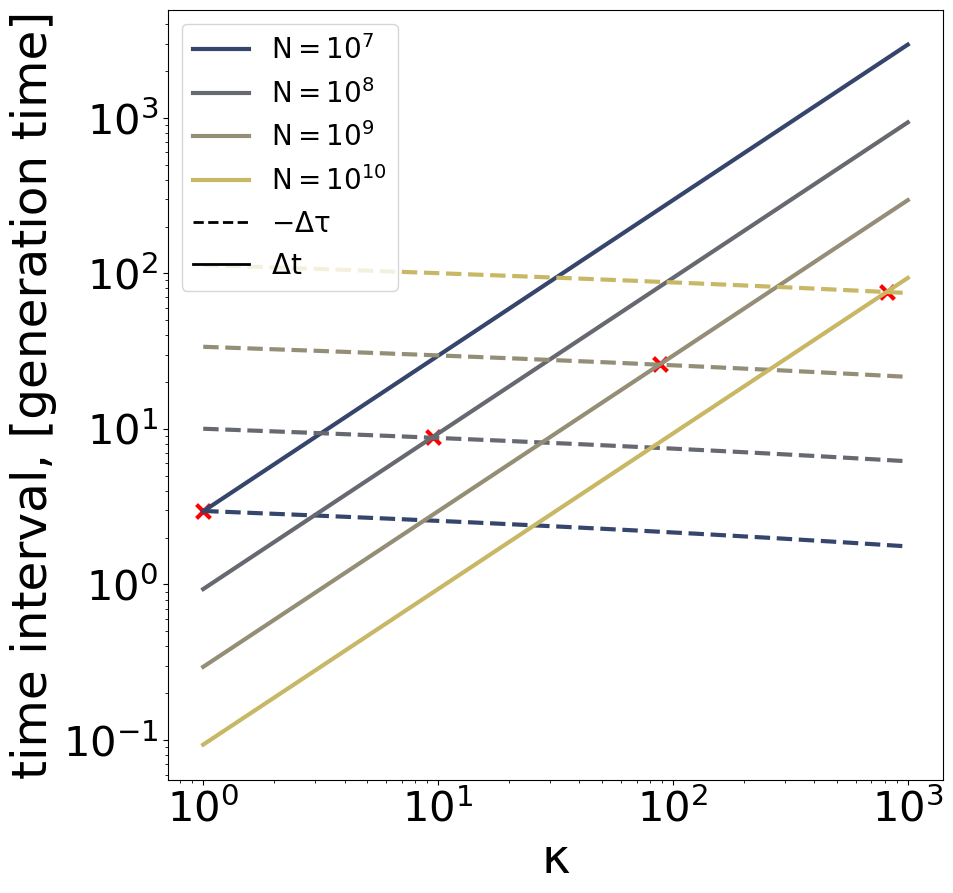

In [23]:
kappa_s_arr = np.logspace(0,3,200,base=10)
N_s = [1e7,1e8,1e9,1e10]
muN_s = mu*np.array(N_s)

fig,axx= plt.subplots(1,1,figsize=(10,10))
colors_N = dict(zip(N_s, sns.color_palette('cividis', len(N_s))))
for N in N_s:
    muN= mu*N
    t1 = kappa_s_arr/(R0-1)* np.sqrt(np.pi/(2*muN*delta))
    t2 = kappa_s_arr/(R0-1)* np.sqrt(9*np.pi/(8*muN*delta))

    sd_t1 = (1-c_d(d1,xi))* (R0-1)/kappa_s_arr * t1
    sd_t2 = (1-c_d(d2,xi))* (R0-1)/kappa_s_arr * t2
    tf_t1 =  np.log(N*(R0-1)/kappa_s_arr*sd_t1)/sd_t1
    tf_t2 =  np.log(N*(R0-1)/kappa_s_arr*sd_t2)/sd_t2
    deltat = t2-t1
    delta_tf= tf_t2-tf_t1
    
    axx.plot(kappa_s_arr, t2-t1, color= colors_N[N],label= fr'$N = 10^{{{np.log10(N):.0f}}}$')
    axx.plot(kappa_s_arr, -delta_tf, linestyle='--',color= colors_N[N])
    deltasum = deltat+delta_tf
    abssum = np.abs(deltasum)
    if deltasum[0]*deltasum[-1]<0:
        axx.scatter(kappa_s_arr[np.argmin(abssum)],deltat[np.argmin(abssum)],color= 'red',marker='x',s=100)
    
# axx.plot(kappa_s_arr, kappa_s_arr, linestyle=':',color= 'grey')
# axx.plot(kappa_s_arr, np.log(N*(R0-1)/kappa_s_arr), linestyle=':',color= 'grey')
axx.set_xscale('log')
axx.set_yscale('log')
axx.set_xlabel(r'$\kappa$')
axx.set_ylabel(r'time interval, [generation time]')
handles= axx.get_legend_handles_labels()[0]
handles+= [Line2D([0], [0], color='black', lw=2, linestyle='--', label = r'$-\Delta \tau$'),
              Line2D([0], [0], color='black', lw=2, label = r'$\Delta t$')]
axx.legend(handles=handles, loc='upper left',fontsize=20)
    # axx.set_ylim(.01,10)
plt.savefig(output_folder+'time_intervals.svg',bbox_inches='tight')

In [14]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

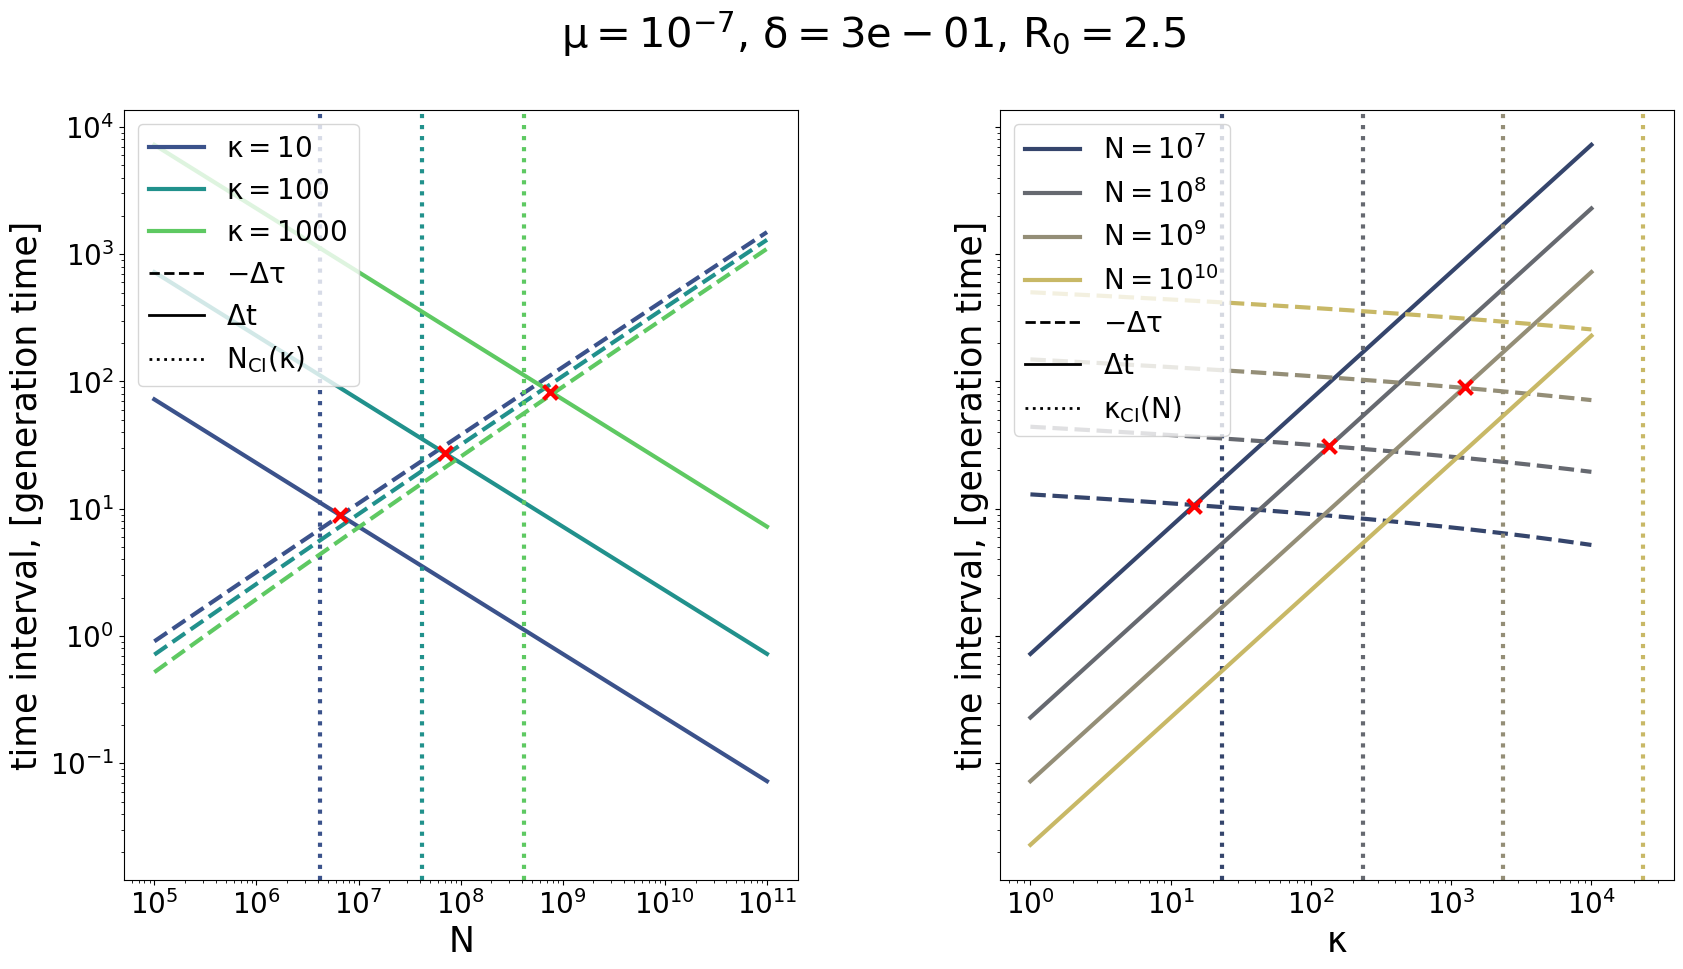

In [15]:
mu = 1e-7
N_arr = np.logspace(5,11,100)
delta = 1/3
kappa_s = [10,100,1000]
R0 = 2.5
muN_arr = mu*N_arr
geom_avg_N = np.exp(np.average(np.log(N_arr)))
c_d = lambda d,xi: np.exp(-d/xi)

colors_kappa = dict(zip(kappa_s, sns.color_palette('viridis', len(kappa_s))))
fig,ax= plt.subplots(1,2,figsize=(20,10),sharey=True)
plt.subplots_adjust(wspace=0.3)

for kappa in kappa_s:   
    d1 = dbar*(1+2*delta)
    deltad = dbar*(1-delta/2)
    d2 = d1 + deltad
    
    t1 = kappa/(R0-1)* np.sqrt(np.pi/(2*muN_arr*delta))
    t2 = kappa/(R0-1)* np.sqrt(9*np.pi/(8*muN_arr*delta))

    sd_t1 = (1-c_d(d1,xi))* (R0-1)/kappa * t1
    sd_t2 = (1-c_d(d2,xi))* (R0-1)/kappa * t2
    tf_t1 =  np.log(N_arr*(R0-1)/kappa*sd_t1)/sd_t1
    tf_t2 =  np.log(N_arr*(R0-1)/kappa*sd_t2)/sd_t2
    delta_t = t2-t1
    delta_tf= tf_t2-tf_t1
    
    ax[0].plot(N_arr, t2-t1, label = r'$\kappa = $'+str(kappa),color= colors_kappa[kappa])
    ax[0].plot(N_arr, -delta_tf, linestyle='--',color= colors_kappa[kappa])
    deltasum = delta_t+delta_tf
    abssum = np.abs(deltasum)
    if deltasum[0]*deltasum[-1]<0:
        ax[0].scatter(N_arr[np.argmin(abssum)],delta_t[np.argmin(abssum)],color= 'red',marker='x',s=100, zorder=10)
    
    # ax[0].axvline(kappa/(6*(R0-1)*mu), linestyle=':',color= colors_kappa[kappa])
    # myval_N = kappa/((R0-1)*mu *delta/(1-np.exp(-delta))*np.log(np.sqrt(geom_avg_N/(mu*delta))*(R0-1)/kappa*(1-np.exp(-delta))))
    myval_N = (2*kappa)/((-1 + R0)*mu*np.log((2*delta)/(mu**2)))
    # myval2_N = (R0**2 + (-1 + R0)*delta*kappa + np.sqrt(R0**2*(R0**2 + 2*(-1 + R0)*delta*kappa)))/((-1 + R0)**2*delta*mu)
    ax[0].axvline(myval_N, linestyle=':',color= colors_kappa[kappa])

ax[0].set_xscale('log')
ax[0].set_yscale('log')

handles = ax[0].get_legend_handles_labels()[0]+[Line2D([0], [0], color='black', lw=2, linestyle='--', label = r'$-\Delta \tau$'),
           Line2D([0], [0], color='black', lw=2, label = r'$\Delta t$'),
           Line2D([0], [0], color='black', lw=2, linestyle=':', label = r'$N_\mathrm{CI}(\kappa) $')]

ax[0].legend(handles=handles, loc='upper left',fontsize=20)

ax[0].set_xlabel(r'$N$',fontsize=25)
ax[0].set_ylabel(r'time interval, [generation time]',fontsize=25)

kappa_s_arr = np.logspace(0,4,200,base=10)
N_s = [1e7,1e8,1e9,1e10]
muN_s = mu*np.array(N_s)

colors_N = dict(zip(N_s, sns.color_palette('cividis', len(N_s))))
for N in N_s:
    muN= mu*N
    t1 = kappa_s_arr/(R0-1)* np.sqrt(np.pi/(2*muN*delta))
    t2 = kappa_s_arr/(R0-1)* np.sqrt(9*np.pi/(8*muN*delta))

    sd_t1 = (1-c_d(d1,xi))* (R0-1)/kappa_s_arr * t1
    sd_t2 = (1-c_d(d2,xi))* (R0-1)/kappa_s_arr * t2
    tf_t1 =  np.log(N*(R0-1)/kappa_s_arr*sd_t1)/sd_t1
    tf_t2 =  np.log(N*(R0-1)/kappa_s_arr*sd_t2)/sd_t2
    delta_t = t2-t1
    delta_tf= tf_t2-tf_t1
    
    ax[1].plot(kappa_s_arr, t2-t1, color= colors_N[N],label= fr'$N = 10^{{{np.log10(N):.0f}}}$')
    ax[1].plot(kappa_s_arr, -delta_tf, linestyle='--',color= colors_N[N])
    deltasum = delta_t+delta_tf
    abssum = np.abs(deltasum)
    if deltasum[0]*deltasum[-1]<0:
        ax[1].scatter(kappa_s_arr[np.argmin(abssum)],delta_t[np.argmin(abssum)],color= 'red',marker='x',s=100, zorder=10)
    # myval_k = N*(R0-1)*mu *delta/(1-np.exp(-delta))*np.log(np.sqrt(N/(mu*delta))*(R0-1)/1000*(1-np.exp(-delta)))
    myval_k = (N*(-1 + R0)*mu*np.log(delta/mu**2))/2
    ax[1].axvline(myval_k, linestyle=':',color= colors_N[N])

# ax[1].plot(kappa_s_arr, kappa_s_arr, linestyle=':',color= 'grey')
# ax[1].plot(kappa_s_arr, np.log(N*(R0-1)/kappa_s_arr), linestyle=':',color= 'grey')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\kappa$',fontsize=25)
ax[1].set_ylabel(r'time interval, [generation time]',fontsize=25)
handles= ax[1].get_legend_handles_labels()[0]
handles+= [Line2D([0], [0], color='black', lw=2, linestyle='--', label = r'$-\Delta \tau$'),
              Line2D([0], [0], color='black', lw=2, label = r'$\Delta t$'),
              Line2D([0], [0], color='black', lw=2, linestyle=':', label = r'$\kappa_\mathrm{CI}(N) $')]
ax[1].legend(handles=handles, loc='upper left',fontsize=20)
fig.suptitle(fr'$\mu = 10^{{{np.log10(mu):.0f}}}$, $\delta = {delta:.0e}$, $R_0 = {R0}$', fontsize=30)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=20)
    
figname = f'deltat_deltatau_vs_N_kappa_mu_{int(np.log10(mu))}_delta_{int(np.log10(delta))}_R0_{R0}.pdf'
fig.savefig(output_folder+figname, bbox_inches='tight')

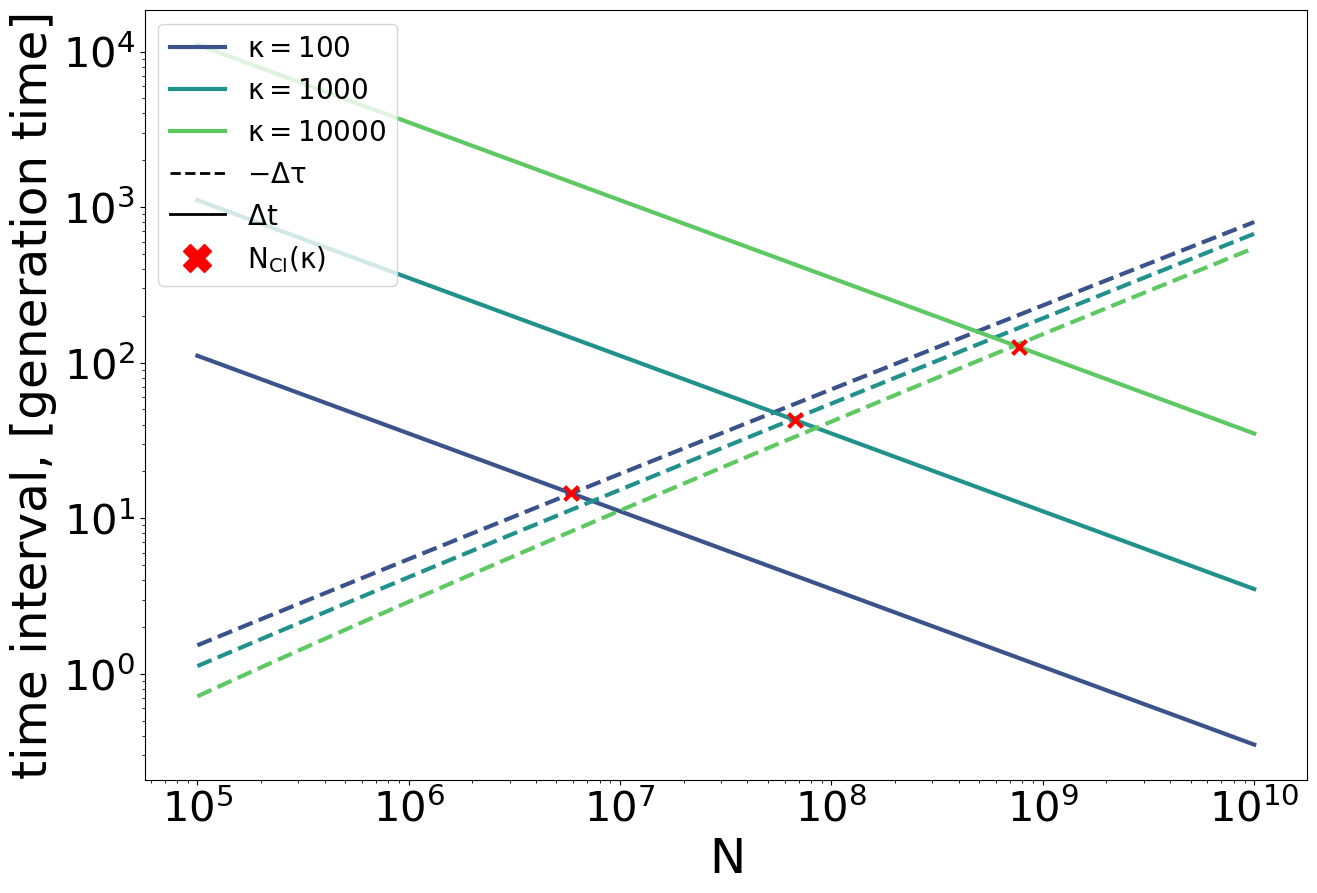

In [16]:
mu = 1e-6
N_arr = np.logspace(5,10,100)
delta = 1/5
kappa_s = [100,1000,10000]
R0 = 5
muN_arr = mu*N_arr

colors_kappa = dict(zip(kappa_s, sns.color_palette('viridis', len(kappa_s))))
fig,axx= plt.subplots(1,1,figsize=(15,10))

for kappa in kappa_s:   
    d1 = 2*dbar
    d2 = d1 + dbar
    t1 = kappa/(R0-1)* np.sqrt(np.pi/(2*muN_arr*delta))
    t2 = kappa/(R0-1)* np.sqrt(9*np.pi/(8*muN_arr*delta))

    sd_t1 = (1-c_d(d1,xi))* (R0-1)/kappa * t1
    sd_t2 = (1-c_d(d2,xi))* (R0-1)/kappa * t2
    tf_t1 =  np.log(N_arr*(R0-1)/kappa*sd_t1)/sd_t1
    tf_t2 =  np.log(N_arr*(R0-1)/kappa*sd_t2)/sd_t2
    deltat = t2-t1
    
    delta_tf= tf_t2-tf_t1
    
    axx.plot(N_arr, t2-t1, label = r'$\kappa = $'+str(kappa),color= colors_kappa[kappa])
    axx.plot(N_arr, -delta_tf, linestyle='--',color= colors_kappa[kappa])
    deltasum = deltat+delta_tf
    abssum = np.abs(deltasum)
    if deltasum[0]*deltasum[-1]<0:
        axx.scatter(N_arr[np.argmin(abssum)],deltat[np.argmin(abssum)],color= 'red',marker='x',s=100, zorder=10)
    
    axx.set_xscale('log')
    axx.set_yscale('log')

handles = axx.get_legend_handles_labels()[0]+[Line2D([0], [0], color='black', lw=2, linestyle='--', label = r'$-\Delta \tau$'),
           Line2D([0], [0], color='black', lw=2, label = r'$\Delta t$'),
           Line2D([0], [0], color='red', lw=2, ms=20, marker='X', ls='', label = r'$N_\mathrm{CI}(\kappa) $')]

axx.legend(handles=handles, loc='upper left',fontsize=20)

axx.set_xlabel(r'$N$')
axx.set_ylabel(r'time interval, [generation time]')
figname = f'deltat_deltatau_vs_N_mu_{int(np.log10(mu))}_delta_{int(np.log10(delta))}_R0_{R0}.svg'
fig.savefig(output_folder+figname, bbox_inches='tight')

In [17]:
data_folder = os.getcwd()+'/data/'

In [18]:
data_flu = pd.read_csv(data_folder+'influenza.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dennytrimcev/Dropbox/Work_Main/onset_antigenic_evolution/5_SI_Figures/data/influenza.csv'

In [ ]:
data_world = data_flu.query('Country=="World"')

In [ ]:
for c in data_world.columns:
    print(c)

Country
Day
Cases of acute respiratory infections
Cases of severe acute respiratory infections
Cases of influenza-like illnesses
Reported deaths caused by severe acute respiratory infections
Cases of influenza-like illness per thousand outpatients
Cases of severe acute respiratory illness per thousand outpatients
A H1N12009 - Sentinel surveillance
A H1N12009 - Non-sentinel surveillance
A H1N12009 - Undefined surveillance
A H1N12009 - All types of surveillance
A H1 - Sentinel surveillance
A H1 - Non-sentinel surveillance
A H1 - Undefined surveillance
A H1 - All types of surveillance
A H3 - Sentinel surveillance
A H3 - Non-sentinel surveillance
A H3 - Undefined surveillance
A H3 - All types of surveillance
A H5 - Sentinel surveillance
A H5 - Non-sentinel surveillance
A H5 - Undefined surveillance
A H5 - All types of surveillance
A H7N9 - Sentinel surveillance
A H7N9 - Non-sentinel surveillance
A H7N9 - Undefined surveillance
A H7N9 - All types of surveillance
A (unknown subtype) - Sentin

In [ ]:

#extract the two time series
data_flu_queried = data_flu.query('Country=="World"')
data_flu_queried = data_flu_queried[['Day','Influenza A - All types of surveillance','Influenza B - All types of surveillance', 'Cases of influenza-like illnesses']]
data_flu_queried = data_flu_queried.dropna()

data_flu_queried['Total flu cases'] = data_flu_queried['Influenza A - All types of surveillance']+data_flu_queried['Influenza B - All types of surveillance']
#transform dates to numbers
data_flu_queried['Day_count'] = pd.to_datetime(data_flu_queried['Day']).sub(pd.Timestamp('2009-01-05')).dt.days
# data_flu_queried['Week'] = pd.cut(data_flu_queried['Day'], bins=range(0, 400, 7), labels=range(0, 400, 7)[:-1])
geom_avg_weekly_counts = np.exp(np.average(np.log(data_flu_queried['Total flu cases'])))
arithm_avg_weekly_counts = np.average(data_flu_queried['Total flu cases'])
print(f'arithm_avg_weekly_counts = {arithm_avg_weekly_counts:.1e}, geom_avg_weekly_counts = {geom_avg_weekly_counts:.1e}')
geom_avg_ILI = np.exp(np.average(np.log(data_flu_queried['Cases of influenza-like illnesses'])))
arithm_avg_ILI = np.average(data_flu_queried['Cases of influenza-like illnesses'])
print(f'arithm_avg_ILI = {arithm_avg_ILI:.1e}, geom_avg_ILI = {geom_avg_ILI:.1e}')

arithm_avg_weekly_counts = 9.8e+03, geom_avg_weekly_counts = 4.1e+03
arithm_avg_ILI = 1.8e+05, geom_avg_ILI = 1.1e+05


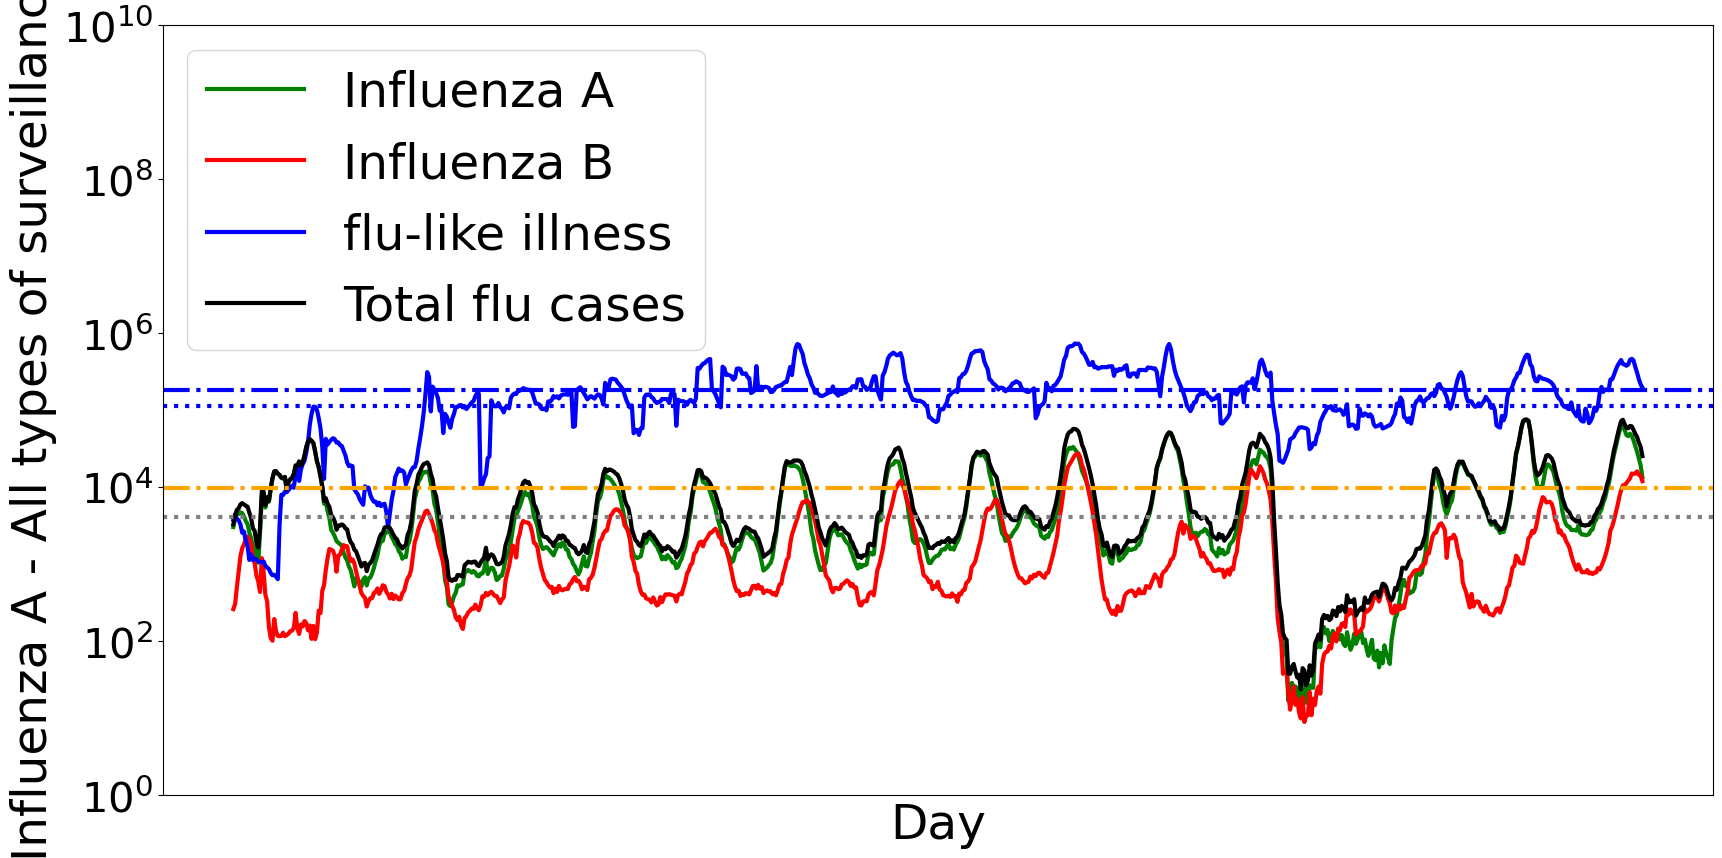

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data=data_world, x='Day', y='Influenza A - All types of surveillance',label='Influenza A',color='green')
sns.lineplot(data=data_world, x='Day', y='Influenza B - All types of surveillance',label='Influenza B',color='red')
sns.lineplot(data=data_world, x='Day', y='Cases of influenza-like illnesses',label='flu-like illness',color='blue')
sns.lineplot(data=data_flu_queried, x='Day', y='Total flu cases',label='Total flu cases',color='black')
ax.set_xticks([])
ax.axhline(geom_avg_weekly_counts, linestyle=':',color='grey')
ax.axhline(arithm_avg_weekly_counts, linestyle='-.',color='orange')
ax.axhline(geom_avg_ILI, linestyle=':',color='blue')
ax.axhline(arithm_avg_ILI, linestyle='-.',color='blue')
ax.set_ylim(1,1e10)
ax.set_yscale('log')


In [ ]:
np.log10(10**10/(5*52))

7.585026652029182

In [ ]:

#extract the two time series
data_flu = data_flu.query('Country=="World"')
data_flu = data_flu[['Day','Influenza A - All types of surveillance','Influenza B - All types of surveillance']]
data_flu = data_flu.dropna()

data_flu['Total flu cases'] = data_flu['Influenza A - All types of surveillance']+data_flu['Influenza B - All types of surveillance']
#transform dates to numbers
data_flu['Day_count'] = pd.to_datetime(data_flu['Day']).sub(pd.Timestamp('2009-01-05')).dt.days
# data_flu['Week'] = pd.cut(data_flu['Day'], bins=range(0, 400, 7), labels=range(0, 400, 7)[:-1])
geom_avg_weekly_counts = np.exp(np.average(np.log(data_flu['Total flu cases'])))
arithm_avg_weekly_counts = np.average(data_flu['Total flu cases'])
print(geom_avg_weekly_counts, arithm_avg_weekly_counts)

4072.7775350767533 9777.320302648171
